In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import random
from tensorflow.keras.datasets import fashion_mnist
# load dataset
(x_train_org, y_train_org), (x_test_org, y_test_org) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


After loading the Fashion-MNIST dataset using keras library, we vectorize it and do normalization on train and test data.
Then, we apply one-hot encoding on the class labels.


In [ ]:
# Vectorizing data
#def vectorize(data):
#    X, Y, Z = data.shape
#    vectorized_data=np.zeros((X,Y*Z))
#    for i in range(X):
#        for j in range(Y):
#            vectorized_data[i,j*Z:(j+1)*Z]=data[i,j,:]
#   return vectorized_data
#x_train=vectorize(x_train_org)
#x_test=vectorize(x_test_org)

x_train=x_train_org.reshape((x_train_org.shape[0], -1))
x_test=x_test_org.reshape((x_test_org.shape[0], -1))

# Centering and Normalization
x_train = x_train - np.mean(x_train)
x_train = x_train / np.std(x_train)

x_test = x_test - np.mean(x_test)
x_test = x_test / np.std(x_test)

# One-hot encoding
y_train=pd.Series(y_train_org)
y_train=pd.get_dummies(y_train).to_numpy()

y_test=pd.Series(y_test_org)
y_test=pd.get_dummies(y_test).to_numpy()


# Adding a bias of 1 to all datapoints
#x_train=np.insert(x_train, x_train.shape[1], values=1, axis=1)
#x_test=np.insert(x_test, x_test.shape[1], values=1, axis=1)

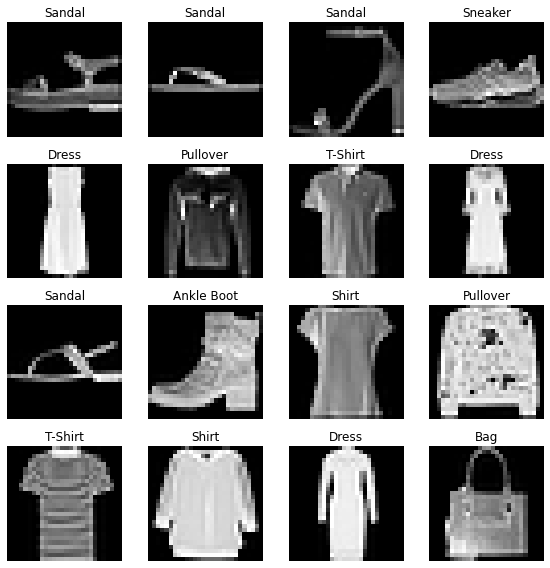

In [ ]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))

for i in range(1, columns * rows+1):
    data_idx = np.random.randint(len(x_train_org))
    img = x_train_org[data_idx].reshape([28, 28])
    label = labels_map[y_train_org[data_idx]]

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

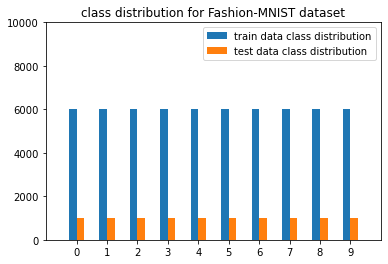

In [ ]:
target_count_train=pd.Series(y_train_org)
target_count_test=pd.Series(y_test_org)
target_count_train=target_count_train.value_counts().sort_index()
target_count_test=target_count_test.value_counts().sort_index()

plt.bar(target_count_train.index-0.125, target_count_train, width=0.25, label='train data class distribution')
plt.bar(target_count_test.index +0.125, target_count_test, width=0.25,label='test data class distribution')
plt.title('class distribution for Fashion-MNIST dataset')
plt.ylim([0,10000])
plt.xlim([-1,10])
plt.xticks(range(0,10))
plt.legend()
plt.show()

The class MLP consists of 5 functions:
1.   initialization of weights, activation functions, layers and other class parameters.
2.   Feedforward: applying feed-forward calculations on the input data and computing matrices on each layer and at the end applying softmax.
3.   Backpropagation: Calculating derivative of the weights by implementing back propagation.
4.   Fit: training model on a specific mini-batch
5.   Predict: predicting labels of test data

Other functions are also defined for different activation functions, derivative of activation functions, calculating loss (softmax cross-entropy loss) and evaluating accurcy of the predictions.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

class MLP:
    
    def __init__(self, num_input=784, num_hidden_layer=1, hidden_layers=[3,3] , num_class=10, 
                 type_activation=[1,1], bias=True, dropout=False):
        self.num_input=num_input
        self.hidden_layers=hidden_layers
        self.num_class=num_class
        self.num_hidden_layer=num_hidden_layer
        self.type_activation=type_activation
        self.dropout=dropout
        
        # if bias:
        #     self.num_input=num_input+1
        #     self.hidden_layers=[i+1 for i in hidden_layers]
          
        if num_hidden_layer==0:
            self.layers=[self.num_input]+ [self.num_class]
        else:
            self.layers=[self.num_input] + self.hidden_layers + [self.num_class]
        
        # Initializing random weights for different layers
        # Initializing derivatives
        self.weights=[] # 
        self.derivatives=[]
        self.bias=[]
        self.d_bias=[]
        for i in range(len(self.layers)-1):
            # w=np.zeros((self.layers[i],self.layers[i+1]))+1
            w=np.random.randn(self.layers[i],self.layers[i+1]) * 0.01
            self.weights.append(w)
            
            dw=np.zeros((self.layers[i], self.layers[i + 1]))
            self.derivatives.append(dw)            
            
            b=np.zeros((1,self.layers[i+1]))
            self.bias.append(b+0.01)
            self.d_bias.append(b)
            
        # Initializing activations
        self.activations=[]
        for j in range(len(self.layers)):
            a = np.zeros((10,self.layers[j]))
            self.activations.append(a)
        
        # Initializing type of activation functions in each layer
        #self.type_activation=[]
        #for k in range(len(self.layers)-2):    
        #    self.type_activation.append(0)
        #self.type_activation.append(4)
    
    def feedforward(self,inputs):
        activations=inputs
        self.activations[0]=inputs
        for i,w in enumerate(self.weights):
            if self.dropout:
                rands=np.random.rand(1, self.activations[i].shape[1])
                rands[rands>self.keep_prob]=0
                rands[rands<self.keep_prob]=1
                activations=activations*rands
            layer_input=np.dot(activations,w)
            layer_input=layer_input+self.bias[i]
            activations=activation_functions(layer_input, self.type_activation[i])
            self.activations[i+1]=activations
        return activations
        
    def backpropagation(self, output, y):
        db=np.zeros((y.shape[0],1))+1
        error=output-y
        N=len(self.derivatives)
        self.derivatives[N-1]=np.dot(self.activations[N-1].T,error)
        self.d_bias[N-1]=np.dot(db.T,error)
        error=(np.dot(error, self.weights[N-1].T)) / (error.shape[0]*error.shape[1]*self.keep_prob)
        for i in reversed(range(N-1)):
            act=self.activations[i+1]
            delta=error*derivatives_af(act, n_act=0)
            self.derivatives[i]=np.dot(self.activations[i].T,delta)
            self.d_bias[i]=np.dot(db.T,delta)
            error=(np.dot(delta, self.weights[i].T))/ (error.shape[0]*error.shape[1]*self.keep_prob)
        return self.derivatives , self.d_bias
        
    def fit(self, data, target, optimizer, keep_prob=1):
        self.keep_prob=keep_prob
        self.weights, loss, accuracy=optimizer.run(data, target, self.weights,self.bias, self.feedforward, self.backpropagation)
        return loss, accuracy

    
    def predict(self, x):
        output=self.feedforward(x)
        target=np.argmax(output,1)
        return target
    
    
def activation_functions(x, n_act, gamma=0.1):
    if n_act==0:
        y=x
        y[y<0]=0
    elif n_act==1:
         y=1/(1+np.exp(-x))
    elif n_act==2:
        y=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


    elif n_act==3:
        y=np.zeros((x.shape[0],x.shape[1]))
        for i,w in enumerate(x):
            y[i,:]=[gamma*b if b<0 else b for b in w]    

    elif n_act==4:
        for i in range(x.shape[0]):
            x[i,:] -= np.max(x[i,:])
            sums=np.sum(np.exp(x[i,:]))
            for j in range(x.shape[1]):
                x[i,j]=np.exp(x[i,j])/(sums)
        y=x
    return y

def derivatives_af( x, n_act, gamma=0.1):
    if n_act==0:
        x[x>0]=1
        x[x<0]=0
        d=x
    elif n_act==1:
         d = x*(1-x)
    elif n_act==2:
        d=1-np.tanh(x^2)

    elif n_act==3:
        y=np.zeros((x.shape[0],x.shape[1]))
        for i,w in enumerate(x):
            y[i,:]=[gamma if b<0 else 1 for b in w]

    elif n_act==4:
        N, D=x.shape
        d=np.zeros((N,D,D))
        for k in range(N):
            for i in range(D):
                for j in range(D):
                    if i==j:
                        d[k,i,j]=x[i,i]*(1-x[i,i])
                    else:
                        d[k,i,j]=-x[i,i]*x[i,j]
    return d

def Loss_function( target, output):
    a1=np.sum(output*target , axis=1)
    a2=np.sum(target, axis=1)
    loss=np.sum(-a1-np.log(a2))
    return loss

def evaluate_acc(yh, output):
    accuracy = np.sum(yh == output)/(len(yh))
    return accuracy

Gradient Decent class is implemented based on **Stochastic Gradient Decent**. 
In each loop a mini-batch is selected randomly from datasets and forward and backpropagation is applied on them and weights and biases are updated based on them. **Adam** is applied in the implementation as well. **L2 regularization** is also added for updating weights.

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, epochs=1000, epsilon=1e-8, batch_size=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.epsilon = epsilon
        self.batch_size=batch_size
        
    def run(self, data, target, params, biases, forward_mode, backpropagation):
        norms = np.array([np.inf])
        momentum_w=[]
        rmsprop_w=[]
        momentum_b=[]
        rmsprop_b=[]
        for i in range(len(params)):
            m=np.zeros((params[i].shape[0], params[i].shape[1]))
            momentum_w.append(m) 
            rmsprop_w.append(m)
            
            b=np.zeros((biases[i].shape[0], biases[i].shape[1]))
            momentum_b.append(b) 
            rmsprop_b.append(b)
            
        t = 1
        beta1=0.9
        beta2=0.99
        eps=0.1
        loss=[]
        accuracy=[]
        while np.any(norms > self.epsilon) and t < self.epochs:
            rand=random.sample(range(0, len(target)), self.batch_size)
            x=data[rand,:]
            y=target[rand] 
            output=forward_mode(x)
            
            grad_w, grad_b=backpropagation(output, y)
            loss.append(Loss_function(y,output))
            
            yh=np.argmax(output, 1)
            y_out=np.argmax(y, 1)
            accuracy.append(evaluate_acc(yh,y_out))
           
            for p in range(len(params)):
                # params[p] -= self.learning_rate * grad_w[p]
                # biases[p] -= self.learning_rate * grad_b[p]
                momentum_w[p] = beta1 * momentum_w[p] + (1 - beta1) * (grad_w[p])#+0.005*params[p])   #L2 Regularization
                m_w_corrected = momentum_w[p] / (1 - np.power(beta1, t))
                rmsprop_w[p] = beta2 * rmsprop_w[p] + (1 - beta2) * np.square(grad_w[p])
                r_w_corrected = rmsprop_w[p] / (1 - np.power(beta2, t))
                params[p] -= self.learning_rate * m_w_corrected / (np.sqrt(r_w_corrected) + eps)
                
                
                momentum_b[p] = beta1 * momentum_b[p] + (1 - beta1) * grad_b[p]
                m_b_corrected = momentum_b[p] / (1 - np.power(beta1, t))
                rmsprop_b[p] = beta2 * rmsprop_b[p] + (1 - beta2) * np.square(grad_b[p])
                r_b_corrected = rmsprop_b[p] / (1 - np.power(beta2, t))
                biases[p] -= self.learning_rate * m_b_corrected / (np.sqrt(r_b_corrected) + eps)
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad_w])
            
        return params, loss, accuracy

In this section two functions are defined for finding the best **Learning rate** and number of **Epochs** for each model.

In [ ]:
def smoothing(x,n):
    x_smooth=[]
    for i in range(len(x)-n):
        x_smooth.append(np.mean(x[i+1:i+n]))
    return x_smooth

def epoch_optimization(model, epochs, lr):
    accuracy_train=[]
    accuracy_test=[]
    i=0
    for p in epochs:
        optimizer1 = GradientDescent(learning_rate=lr, epochs=p, batch_size=100)
        _,_= model.fit(x_train, y_train, optimizer1)
        yh_train=model.predict(x_train)
        yh_test=model.predict(x_test)
        accuracy_train.append(evaluate_acc(yh_train,y_train_org))
        accuracy_test.append(evaluate_acc(yh_test,y_test_org))
        epochs[i]/=600
        i+=1
    plt.plot(epochs, accuracy_train, label='train')
    plt.plot(epochs, accuracy_test, label='test')
    plt.ylabel("accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return accuracy_train, accuracy_test

def LR_optimization(model, learning_rate, epochs):
    accuracy_test=[]
    for lr in learning_rate:
        optimizer1 = GradientDescent(learning_rate=lr, epochs=epochs, batch_size=100)
        loss,accuracy_train= model.fit(x_train, y_train, optimizer1)
        yh_test=model.predict(x_test)
        accuracy_test.append(evaluate_acc(yh_test,y_test_org))
        accuracy_train=smoothing(accuracy_train,20)
        plt.plot(accuracy_train, label=lr)
    plt.ylabel("accuracy")
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

    plt.plot(learning_rate, accuracy_test)
    plt.ylabel("Test accuracy")
    plt.xlabel("Learning Rate")
    plt.show()
    return 

**Task 1.1**: Model with no hidden layers:
(first graph is test accuracy vs. iterations)

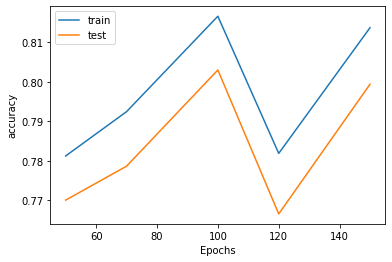

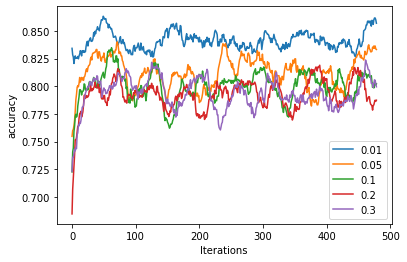

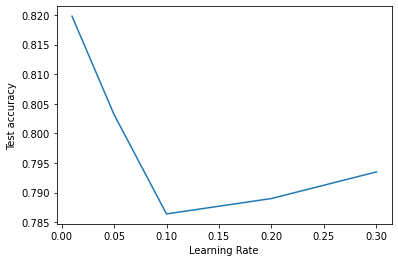

In [ ]:
model = MLP(num_input=784, num_hidden_layer=0, hidden_layers=[] , num_class=10)
epoch_optimization(model, epochs=[50,70,100,120,150], lr=0.1)
LR_optimization(model, learning_rate=[0.01,0.05,0.1,0.2,0.3], epochs=500)

accuracy of model with no hidden layer:  80.41


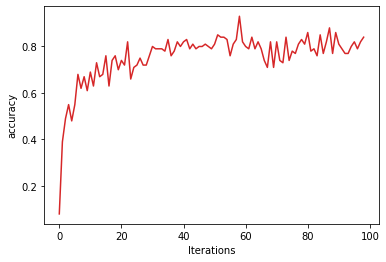

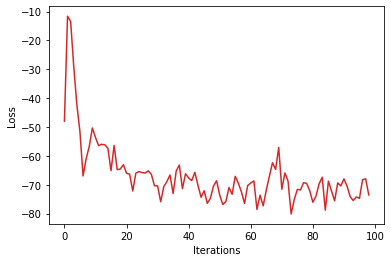

In [ ]:
# Training the model with no hidden layers
model = MLP(num_input=784, num_hidden_layer=0, hidden_layers=[] , num_class=10)
optimizer = GradientDescent(learning_rate=0.01, epochs=100, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with no hidden layer: ", accuracy*100)

#accuracy_train=smoothing(accuracy_train,2)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

#loss=smoothing(loss,2)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

**Task 1.2**: Model with **one** hidden layer with **ReLU** activation (first graph is test accuracy vs. iterations)

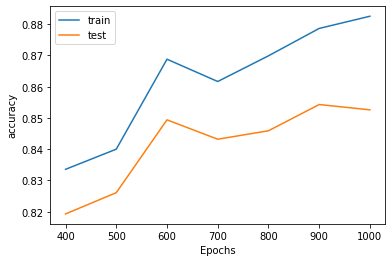

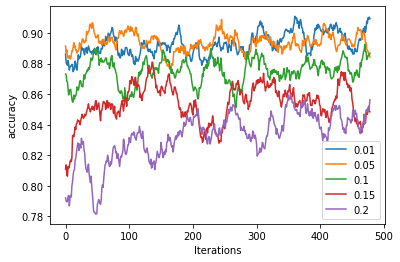

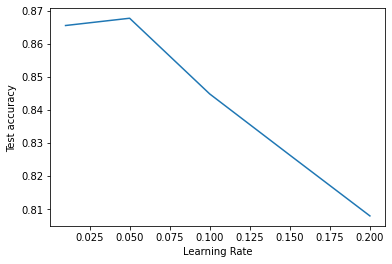

In [ ]:
model = MLP(num_input=784, num_hidden_layer=1, hidden_layers=[128] , type_activation=[0,4], num_class=10)
epoch_optimization(model, epochs=[400,500,600,700,800,900,1000], lr=0.1)
LR_optimization(model, learning_rate=[0.01,0.05,0.1,0.15,0.2],epochs=1000)

accuracy of model with one hidden layer:  85.47


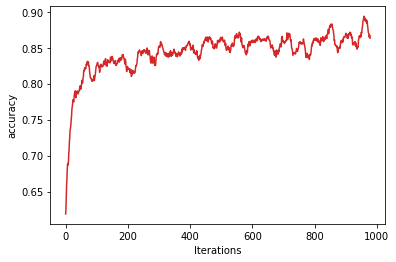

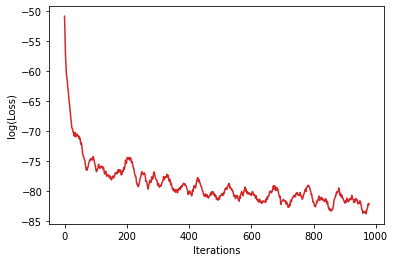

In [ ]:
# Training the model with one hidden layer with ReLU activation
model = MLP(num_input=784, num_hidden_layer=1, hidden_layers=[128], type_activation=[0,4], num_class=10)
optimizer = GradientDescent(learning_rate=.05, epochs=1200, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with one hidden layer: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("log(Loss)")
plt.xlabel("Iterations")
plt.show()


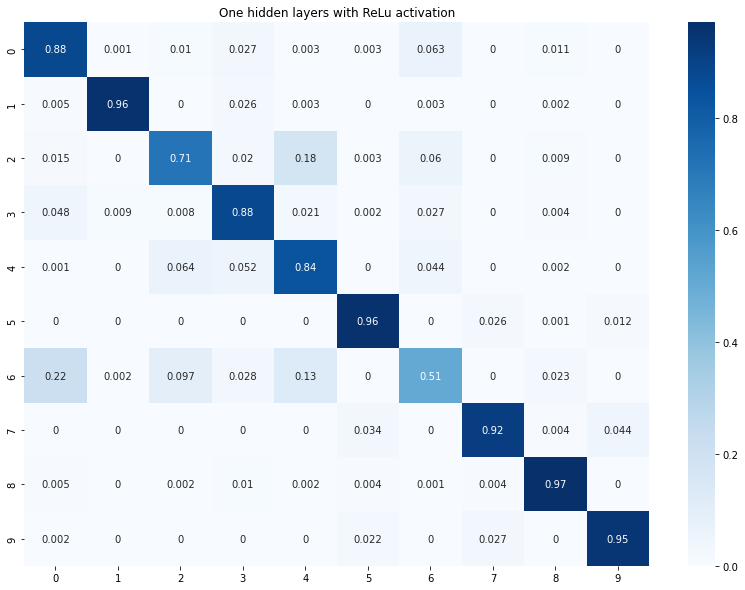

In [ ]:
# Training the model with two hidden layers with ReLu activations
model = MLP(num_input=784, num_hidden_layer=1, hidden_layers=[128], type_activation=[0,4], num_class=10)
optimizer = GradientDescent(learning_rate=0.05, epochs=1200, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
def draw_cf_matrix(y_test,y_pred,width,height,title):
  cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  ax.set_title(title);
  plt.gcf().set_size_inches(width, height)
  plt.show()

draw_cf_matrix(y_test_org,yh, 14,10, 'One hidden layers with ReLu activation')

**Task 1.3**: Model with **two** hidden layers with **ReLU** activations (last graph is test accuracy vs. iterations)

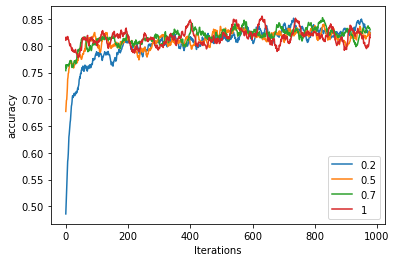

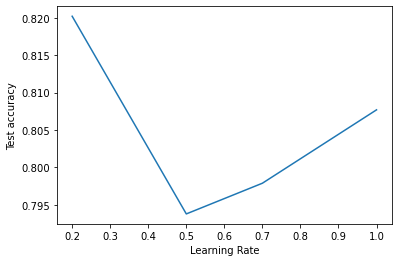

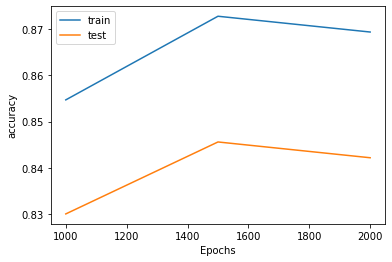

In [ ]:
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] , type_activation=[0,0,4], num_class=10)
LR_optimization(model, learning_rate=[0.2,0.5,0.7,1],epochs=1000)
epoch_optimization(model, epochs=[1000,1500,2000], lr=0.2)

This figure is showing the accuracy of train and test data with respect to **number of epochs** for **MLP**

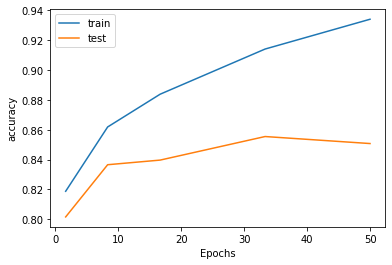

In [ ]:
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] , type_activation=[0,0,4], num_class=10)
acc_train,acc_test=epoch_optimization(model, epochs=[1000,5000,10000,20000,30000], lr=0.5)


accuracy of model with two hidden layers:  82.50999999999999


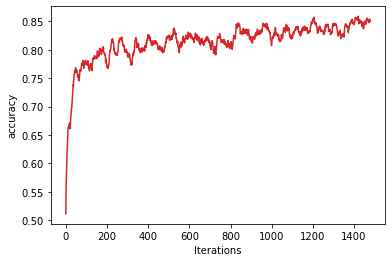

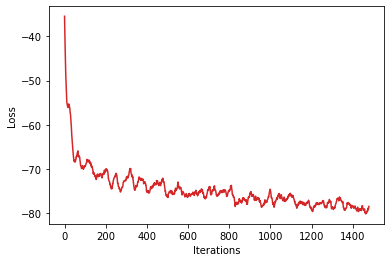

In [ ]:
# Training the model with two hidden layers with ReLu activations
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128], type_activation=[0,0,4], num_class=10)
optimizer = GradientDescent(learning_rate=0.5, epochs=6000, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with two hidden layers: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

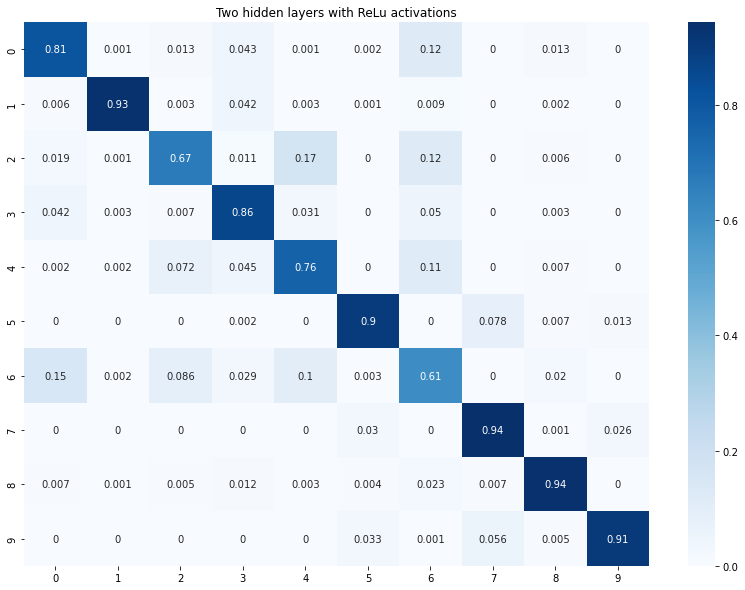

In [ ]:
# Training the model with two hidden layers with ReLu activations
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128], type_activation=[0,0,4], num_class=10)
optimizer = GradientDescent(learning_rate=0.2, epochs=1500, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
def draw_cf_matrix(y_test,y_pred,width,height,title):
  cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  ax.set_title(title);
  plt.gcf().set_size_inches(width, height)
  plt.show()
  
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}
draw_cf_matrix(y_test_org,yh, 14,10, 'Two hidden layers with ReLu activations')

**Task 2.1**: Model with **two** hidden layers with **tanh** activations. (first graph is test accuracy vs. iterations)

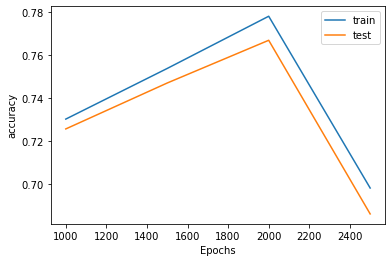

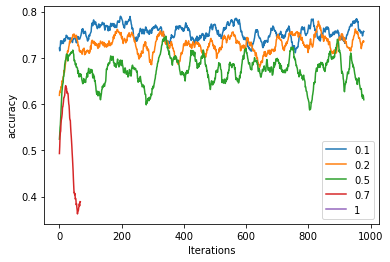

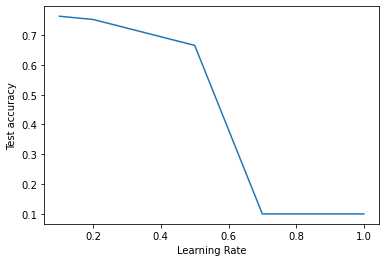

In [ ]:
# Optimizing model for two hidden layers with "tanh" activation functions
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] , type_activation=[2,2,4], num_class=10)
epoch_optimization(model, epochs=[1000,1500,2000,2500], lr=0.5)
LR_optimization(model, learning_rate=[0.1,0.2,0.5,0.7,1],epochs=1000)

accuracy of model with two hidden layers:  78.48


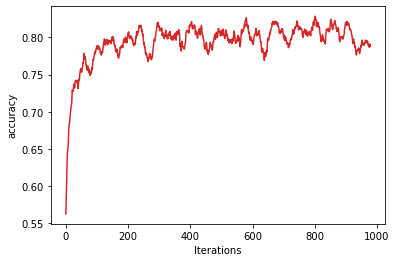

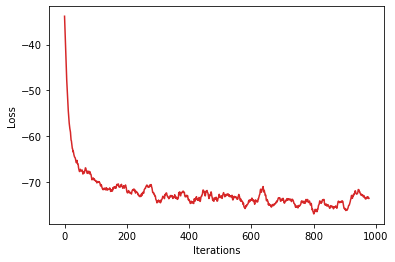

In [ ]:
# Training the model with two hidden layers with "tanh" activation functions
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128], type_activation=[2,2,4], num_class=10)
optimizer = GradientDescent(learning_rate=0.1, epochs=1000, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with two hidden layers: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

**Task 2.2**: Model with **two** hidden layers with **Leaky-ReLU** activations.(first graph is test accuracy vs. iterations)

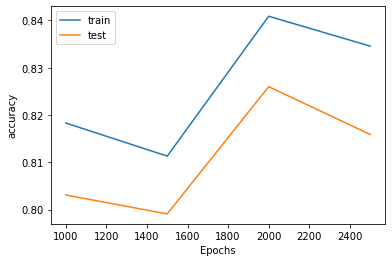

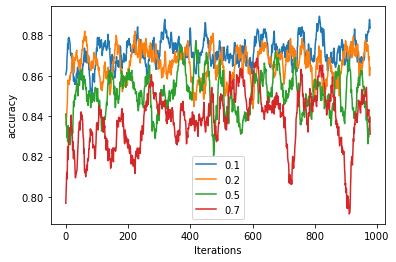

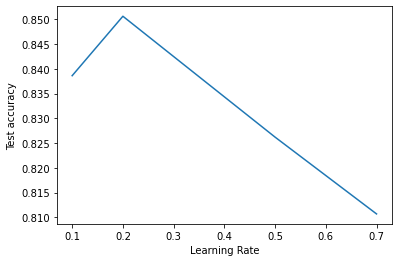

In [ ]:
# Optimizing model for two hidden layers with "Leaky-ReLU" activation functions
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] , type_activation=[3,3,4], num_class=10)
epoch_optimization(model, epochs=[1000,1500,2000,2500], lr=0.5)
LR_optimization(model, learning_rate=[0.1,0.2,0.5,0.7],epochs=1000)

accuracy of model with two hidden layers:  81.92


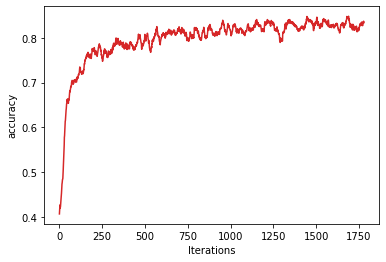

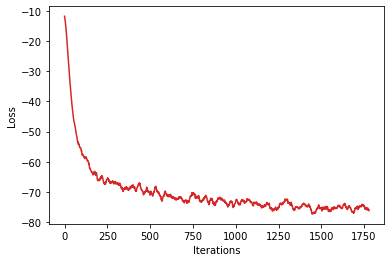

In [ ]:
# Training the model with two hidden layers with "Leaky-ReLU" activation functions
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128], type_activation=[3,3,4], num_class=10)
optimizer = GradientDescent(learning_rate=0.2, epochs=2000, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with two hidden layers: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

**Task 3**: Model with **two** hidden layers with **ReLU** activations with **dropout**

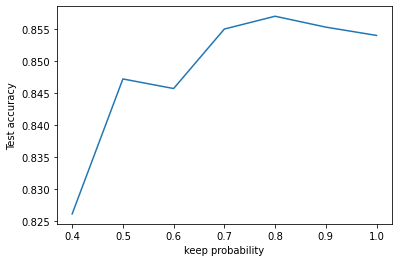

In [ ]:
# Training the model with two hidden layers with ReLu activations with dropout
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] ,type_activation=[0,0,4], num_class=10, dropout=True)
optimizer = GradientDescent(learning_rate=1, epochs=3500, batch_size=100)
accuracy=np.zeros((7,2))
j=0
for i in [0.4,0.5,0.6,0.7,0.8,0.9,1]:
    loss, accuracy_train= model.fit(x_train, y_train, optimizer,keep_prob=i)
    yh=model.predict(x_test)
    acc = np.sum(yh == y_test_org)/(len(yh))
    accuracy[j,:]=[i,acc]
    j+=1

plt.plot(accuracy[:,0], accuracy[:,1])
plt.xlabel("keep probability")
plt.ylabel("Test accuracy")
plt.show()

accuracy of model with two hidden layers:  76.25


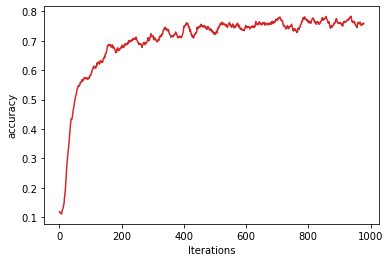

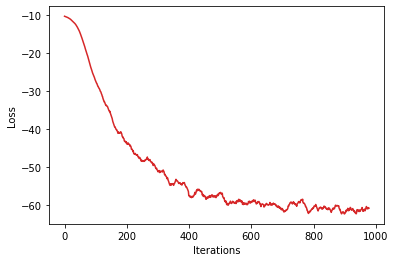

In [ ]:
# Training the model with two hidden layers with ReLu activations with l2 regularization
model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] ,type_activation=[0,0,4], num_class=10, dropout=False)
optimizer = GradientDescent(learning_rate=.01, epochs=1000, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with two hidden layers: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

**Task 4**: Model with **two** hidden layers with **ReLU** activations without **normalization**

accuracy of model with two hidden layers:  80.55


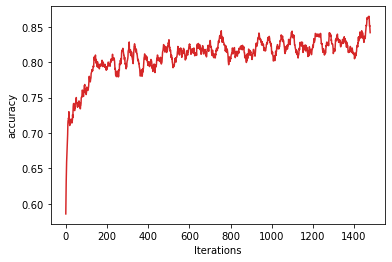

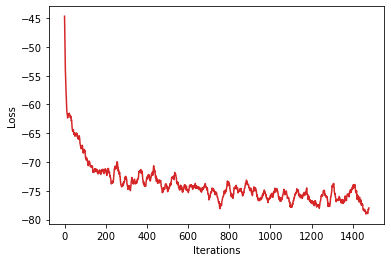

In [ ]:
# Training the model with two hidden layers with ReLu activations without normalization
x_train_v=x_train_org.reshape((x_train_org.shape[0], -1))
x_test_v=x_test_org.reshape((x_test_org.shape[0], -1))

model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128] ,type_activation=[0,0,4], num_class=10)
optimizer = GradientDescent(learning_rate=.01, epochs=1500, batch_size=100)
loss, accuracy_train= model.fit(x_train_v, y_train, optimizer)
yh=model.predict(x_test_v)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with two hidden layers: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

accuracy of model with two hidden layers:  67.06


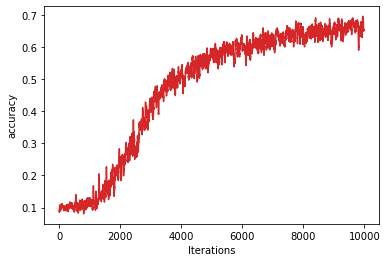

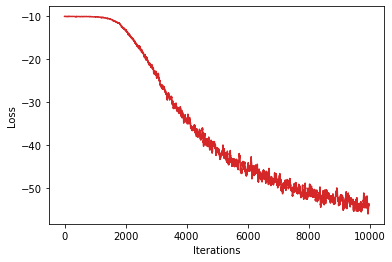

In [ ]:
model = MLP(num_input=784, num_hidden_layer=4, hidden_layers=[128,128,64,64] ,type_activation=[0, 2, 0, 0, 4], num_class=10)
optimizer = GradientDescent(learning_rate=0.05, epochs=10000, batch_size=100)
loss, accuracy_train= model.fit(x_train, y_train, optimizer)
yh=model.predict(x_test)
accuracy = np.sum(yh == y_test_org)/(len(yh))
print("accuracy of model with two hidden layers: ", accuracy*100)

accuracy_train=smoothing(accuracy_train,20)
plt.plot(accuracy_train,  color='tab:red')
plt.ylabel("accuracy")
plt.xlabel("Iterations")
plt.show()

loss=smoothing(loss,20)
plt.plot(loss, label='Loss function', color='tab:red')
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

Searching for best **MLP** architecture

In [ ]:
def gridsearch_MLP( max_depth, rng_width):
    hl=[]
    acc_1=[]
    acc_2=[]
    all_results=np.zeros((4*len(rng_width)*max_depth,5))
    type_activation=[0]
    j=0
    for l in range(1,max_depth+1):
        results=np.zeros((4*len(rng_width),5))
        hl.append(0)
        type_activation.append(4)
        i=0
        print(j)
        for ac in range(4):
            type_activation[j]=ac
            for h in rng_width:
                    hl[j]=h
                    optimizer = GradientDescent(learning_rate=0.15, epochs=l*l*1000, batch_size=100)
                    model=MLP(num_input=784, num_hidden_layer=l, hidden_layers=hl,type_activation=type_activation, num_class=10)
                    _,_=model.fit(x_train, y_train, optimizer)
                    acc_1=evaluate_acc(model.predict(x_train),y_train_org)
                    acc_2=evaluate_acc(model.predict(x_test),y_test_org)
                    results[i,:]=[l,ac,h,acc_1,acc_2]
                    i+=1
        a=np.where(results==np.max(results[:,4]))
        type_activation[j]=(results[a[0][0],1]).astype(np.int64)
        hl[j]=(results[a[0][0],2]).astype(np.int64)
        all_results[12*(l-1):12*l,:]=results[:,:]
        print(results)
        j+=1
    num_hidden_layer=l
    return num_hidden_layer, hl, type_activation, all_results

In [ ]:
num_hidden_layer_gs, hl_gs, type_activation_gs, all_results_gs= gridsearch_MLP( max_depth=5, rng_width=[256,128,64])

0
[[  1.           0.         256.           0.84491667   0.8268    ]
 [  1.           0.         128.           0.84243333   0.8308    ]
 [  1.           0.          64.           0.82915      0.81      ]
 [  1.           1.         256.           0.77581667   0.7589    ]
 [  1.           1.         128.           0.77611667   0.7643    ]
 [  1.           1.          64.           0.77821667   0.7694    ]
 [  1.           2.         256.           0.75768333   0.7479    ]
 [  1.           2.         128.           0.7381       0.7317    ]
 [  1.           2.          64.           0.7214       0.7123    ]
 [  1.           3.         256.           0.775        0.7618    ]
 [  1.           3.         128.           0.79848333   0.7859    ]
 [  1.           3.          64.           0.81458333   0.802     ]]
1
[[  2.           0.         256.           0.86225      0.833     ]
 [  2.           0.         128.           0.85645      0.8283    ]
 [  2.           0.          64.           

Effect of **Training size** on **test accuracy** for **MLP** modle

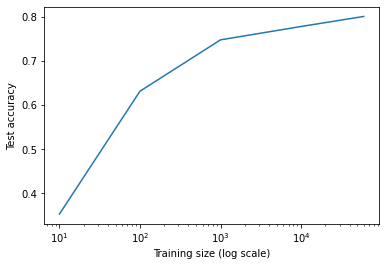

In [ ]:
# Training the model with two hidden layers with ReLu activations
accuracies=np.zeros((5,2))
j=0
for i in [10,100,1000,10000,60000]:
    rand=random.sample(range(0, len(y_train)), i)
    x=x_train[rand,:]
    y=y_train[rand] 
    model = MLP(num_input=784, num_hidden_layer=2, hidden_layers=[128,128], type_activation=[0,0,4], num_class=10)
    optimizer = GradientDescent(learning_rate=0.2, epochs=1500, batch_size=10)
    loss, accuracy_train= model.fit(x, y, optimizer)
    yh=model.predict(x_test)
    acc = np.sum(yh == y_test_org)/(len(yh))
    accuracies[j,:]=[i, acc]
    j+=1

plt.plot(accuracies[:,0],accuracies[:,1])
plt.ylabel("Test accuracy")
plt.xlabel("Training size (log scale)")
plt.xscale("log")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import random
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, models
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 133 kB 4.5 MB/s 


In [ ]:
# https://www.tensorflow.org/tutorials/keras/keras_tuner

def CNN(hp):
  model = keras.Sequential()

  # Input Layer
  #model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)))

  # Convolutional layers

  hp_num_filters = hp.Int('filters', min_value=16, max_value=128, step=16)
  hp_stride = hp.Int('stride', min_value=1, max_value=5, step=1)

  #hp_stride = 1
  #hp_num_filters=32
  
  model.add(layers.Conv2D(hp_num_filters, kernel_size=(3,3), strides=hp_stride, padding='valid', activation='relu', input_shape=(28, 28, 1)))
  model.add(layers.Conv2D(hp_num_filters, kernel_size=(3,3), strides=hp_stride, padding='valid', activation='relu'))
  model.add(layers.Flatten())

  # Fully connected layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))

   # Output layer
  model.add(layers.Dense(10))

  hp_lr = hp.Choice('learning_rate', values=[1.0, 0.1, 0.01, 0.001, 0.0001])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

tuner = kt.Hyperband(CNN,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)
x_train_new = np.array([x.reshape((28, 28, 1)) for x in x_train])
x_test_new = np.array([x.reshape((28, 28, 1)) for x in x_test])

tuner.search(x_train_new, y_train, epochs=10, validation_split=0.1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps)

Trial 30 Complete [00h 01m 44s]
val_accuracy: 0.8451666831970215

Best val_accuracy So Far: 0.9114999771118164
Total elapsed time: 00h 34m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(best_hps.get('filters'))
print(best_hps.get('stride'))
print(best_hps.get('learning_rate'))

96
2
0.001


In [ ]:
def model(training_size, num_filters, kernel, stride, pad, lr,epochs=1):

  x_train_new = np.array([x.reshape((28, 28, 1)) for x in x_train][:training_size])
  x_test_new = np.array([x.reshape((28, 28, 1)) for x in x_test][:training_size])
  y_train_new = y_train[:training_size]
  y_test_new = y_test[:training_size]

  # CNN
  model = models.Sequential()

  # Convolutional layers
  model.add(layers.Conv2D(num_filters, kernel_size=kernel, strides=stride, padding=pad, activation='relu', input_shape=(28, 28, 1)))
  model.add(layers.Conv2D(num_filters, kernel_size=kernel, strides=stride, padding=pad, activation='relu'))
  model.add(layers.Flatten())

  # Fully connected layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))

  # Output layer
  model.add(layers.Dense(10))

  # Compile model
  # Taken from documentation
  adam = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=adam,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Train
  model.fit(x_train_new, y_train_new, epochs=epochs)

  # Evaluate
  test_loss, test_acc = model.evaluate(x_test_new, y_test_new, verbose=2)
  train_loss, train_acc = model.evaluate(x_train_new, y_train_new, verbose=2)
  return(train_acc, test_acc)

#for i in range(1, 6):
#  print("Training size: 10^"+str(i))
#  train_acc, test_acc = model(training_size=10**i, num_filters=best_hps.get('filters'), kernel=(3,3), stride=best_hps.get('stride'), pad="valid", lr=best_hps.get('learning_rate'))
#  print("Train accuracy:", train_acc)
#  print("Test accuracy:", test_acc)




Training size: 10^1
1/1 [==============================] - 0s 443ms/step - loss: 2.3386 - accuracy: 0.0000e+00
1/1 - 0s - loss: 2.2860 - accuracy: 0.1000 - 219ms/epoch - 219ms/step
1/1 - 0s - loss: 2.0686 - accuracy: 0.6000 - 36ms/epoch - 36ms/step
Train accuracy: [2.06855845451355, 0.6000000238418579]
Test accuracy: 0.10000000149011612
Training size: 10^2
4/4 [==============================] - 1s 32ms/step - loss: 2.2135 - accuracy: 0.1700
4/4 - 0s - loss: 1.9847 - accuracy: 0.3900 - 249ms/epoch - 62ms/step
4/4 - 0s - loss: 1.7883 - accuracy: 0.6100 - 60ms/epoch - 15ms/step
Train accuracy: [1.788327932357788, 0.6100000143051147]
Test accuracy: 0.38999998569488525
Training size: 10^3
32/32 [==============================] - 2s 25ms/step - loss: 1.3340 - accuracy: 0.5360
32/32 - 0s - loss: 0.9169 - accuracy: 0.6360 - 323ms/epoch - 10ms/step
32/32 - 0s - loss: 0.8328 - accuracy: 0.6920 - 189ms/epoch - 6ms/step
Train accuracy: [0.8327919244766235, 0.6919999718666077]
Test accuracy: 0.6359

1875/1875 [==============================] - 64s 33ms/step - loss: 0.3998 - accuracy: 0.8527
313/313 - 2s - loss: 0.3153 - accuracy: 0.8875 - 2s/epoch - 7ms/step
1875/1875 - 14s - loss: 0.2688 - accuracy: 0.9000 - 14s/epoch - 8ms/step
Epoch 1/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.4032 - accuracy: 0.8504
Epoch 2/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2687 - accuracy: 0.9001
Epoch 3/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.2190 - accuracy: 0.9172
Epoch 4/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1819 - accuracy: 0.9318
Epoch 5/5
1875/1875 [==============================] - 48s 26ms/step - loss: 0.1478 - accuracy: 0.9436
313/313 - 2s - loss: 0.2934 - accuracy: 0.8964 - 2s/epoch - 7ms/step
1875/1875 - 14s - loss: 0.1461 - accuracy: 0.9465 - 14s/epoch - 8ms/step
Epoch 1/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3983 - accuracy: 0.8568
Epoc

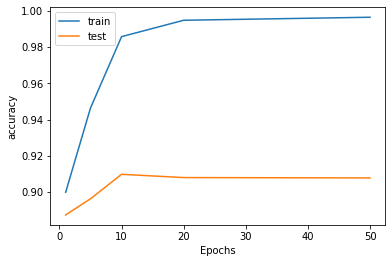

In [ ]:
def model(training_size, num_filters, kernel, stride, pad, lr,epochs=1):

  x_train_new = np.array([x.reshape((28, 28, 1)) for x in x_train][:training_size])
  x_test_new = np.array([x.reshape((28, 28, 1)) for x in x_test][:training_size])
  y_train_new = y_train[:training_size]
  y_test_new = y_test[:training_size]

  # CNN
  model = models.Sequential()

  # Convolutional layers
  model.add(layers.Conv2D(num_filters, kernel_size=kernel, strides=stride, padding=pad, activation='relu', input_shape=(28, 28, 1)))
  model.add(layers.Conv2D(num_filters, kernel_size=kernel, strides=stride, padding=pad, activation='relu'))
  model.add(layers.Flatten())

  # Fully connected layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))

  # Output layer
  model.add(layers.Dense(10))

  # Compile model
  # Taken from documentation
  adam = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=adam,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # Train
  model.fit(x_train_new, y_train_new, epochs=epochs)

  # Evaluate
  test_loss, test_acc = model.evaluate(x_test_new, y_test_new, verbose=2)
  train_loss, train_acc = model.evaluate(x_train_new, y_train_new, verbose=2)
  return(train_acc, test_acc)

accuracy_train=[]
accuracy_test=[]
epoch=[1,5,10,20,50]
for p in epoch:
    train_acc, test_acc = model(training_size=60000, num_filters=96, kernel=(3,3), stride=2, pad="valid", lr=0.001, epochs=p)
    accuracy_train.append(train_acc)
    accuracy_test.append(test_acc)
plt.plot(epoch, accuracy_train, label='train')
plt.plot(epoch, accuracy_test, label='test')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

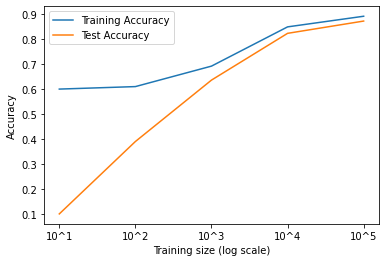

In [ ]:
sizes = ["10^"+str(x) for x in range(1, 6)]
train_acc = [0.6000000238418579, 0.6100000143051147,0.6919999718666077, 0.8492000102996826, 0.8917833566665649]
test_acc = [0.10000000149011612, 0.38999998569488525, 0.6359999775886536, 0.8233000040054321, 0.8725000023841858 ]

plt.plot(sizes, train_acc, label="Training Accuracy")
plt.plot(sizes, test_acc, label="Test Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Training size (log scale)")
plt.show()